## 필요한 라이브러리 import

In [59]:
!pip install datasets

In [60]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from datasets import load_dataset
from sklearn.preprocessing import StandardScaler

## 재현성 보장을 위한 랜덤시드 고정

In [61]:
# 랜덤 시드 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

## dataset load

ETH-USD-2022-01-01_2024-08-30 데이터셋은
- 2022년 1월 ~ 2024년 8월 까지
- 이더리움(ETH)과 미국달러(USD) 간의 시세 데이터를 포함한 시계열 데이터
- input_ids는 256개의 시간 단위로 이루어진 가격 시퀀스
- label은 그 다음 시점에서의 가격

In [88]:
dataset = load_dataset("StockLlama/ETH-USD-2022-01-01_2024-08-30")

# 데이터프레임 변환
df = dataset["train"].to_pandas()

# input_ids를 리스트에서 NumPy 배열로 변환
df["input_ids"] = df["input_ids"].apply(lambda x: np.array(x))

df

,input_ids,label
0,"[91.308495, 93.06198, 91.06491, 92.02197, 84.8...",28.777820
1,"[93.06198, 91.06491, 92.02197, 84.885086, 81.0...",24.001883
2,"[91.06491, 92.02197, 84.885086, 81.01954, 74.4...",22.852409
3,"[92.02197, 84.885086, 81.01954, 74.42368, 71.4...",23.944717
4,"[84.885086, 81.01954, 74.42368, 71.45851, 73.3...",20.007884
...,...,...
711,"[47.109726, 48.74788, 45.899754, 46.122032, 45...",61.417749
712,"[48.74788, 45.899754, 46.122032, 45.230312, 45...",59.431441
713,"[45.899754, 46.122032, 45.230312, 45.839302, 4...",52.911262
714,"[46.122032, 45.230312, 45.839302, 44.68528, 45...",54.952393


In [63]:
print(df.info())  # 데이터 유형 및 결측값 확인
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   input_ids  716 non-null    object 
 1   label      716 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.3+ KB
None
(716, 2)


## sequence data 생성

- 시퀀스 길이는 2로 설정
- 해당 데이터는 이미 256개의 시간단위로 이루어져 있음
- 따라서 time step이 1 이면 256개, 2라면 512로 설정한 것이라고 생각


- create_sequences 함수
  - X와 y를 기반으로 time_step 길이의 sequence를 생성, 각 시퀀스에 대해 예측할 값 seq_y를 생성함

In [248]:
# 시퀀스 생성 함수
def create_sequences(X, y, time_step):
    sequences_X, sequences_y = [], []
    for i in range(len(X) - time_step):
        seq_X = X[i:i+time_step]
        seq_y = y[i+time_step]  # 예측값은 다음 시점의 값
        sequences_X.append(seq_X)
        sequences_y.append(seq_y)
    return np.array(sequences_X), np.array(sequences_y)

# 시퀀스 데이터 생성
time_step = 16  # 원하는 시간 스텝
X = np.stack(df['input_ids'].values)  # X는 시퀀스로 만들 데이터
y = df['label'].values.reshape(-1, 1)  # y는 예측할 라벨

print(len(X))
print(len(X[0]))

716
256


## 데이터 정규화

Standardization 정규화 사용
- Z-score normalization
- 평균이 0, 표준편차가 1로 변환하는 방식
- 시계열 예측에서는 분포의 변화나 데이터의 특성에 대해 신경을 기울여야한다고 생각

In [229]:
# # MinMaxScaler로 정규화
# scaler_X = MinMaxScaler(feature_range=(-1, 1))
# scaler_y = MinMaxScaler(feature_range=(-1, 1))

# X_scaled = scaler_X.fit_transform(X)
# y_scaled = scaler_y.fit_transform(y)

from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

## data split, loader 생성

In [249]:
# 시퀀스 데이터 생성
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_step)

# PyTorch Tensor 변환
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

print(len(X_tensor))
# 데이터 분할 (8:1:1 비율)
train_size = int(len(X_tensor) * 0.8)
val_size = int(len(X_tensor) * 0.1)
test_size = len(X_tensor) - train_size - val_size

dataset = TensorDataset(X_tensor, y_tensor)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader 생성
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 데이터 로더 크기 확인
print(f"train: {len(train_dataset)}")
print(f"valid: {len(val_dataset)}")
print(f"test: {len(test_dataset)}")

700
train: 560
valid: 70
test: 70


## RNN, LSTM, GRU model define

In [231]:
# 🔹 모델 정의
class RNNModel(nn.Module):
    def __init__(self, input_size=256, hidden_size=64, output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # 마지막 hidden state 사용
        out = self.fc(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size=256, hidden_size=64, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # 마지막 hidden state 사용
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size=256, hidden_size=64, output_size=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # 마지막 hidden state 사용
        out = self.fc(out)
        return out

## model train 함수

In [232]:
# 🔹 Loss 함수와 Optimizer 설정
criterion = nn.MSELoss()

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()

        val_losses.append(epoch_val_loss / len(val_loader))

        if (epoch + 1) % 5 == 0:
          print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

# 🔹 학습 수행 (RNN, LSTM, GRU)
epochs = 300

## model train

In [233]:
# RNN
print("Training start: RNN")
rnn_model = RNNModel()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
rnn_train_losses, rnn_val_losses = train_model(rnn_model, train_loader, val_loader, criterion, rnn_optimizer, epochs)

# LSTM
print("Training start: LSTM 모델")
lstm_model = LSTMModel()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
lstm_train_losses, lstm_val_losses = train_model(lstm_model, train_loader, val_loader, criterion, lstm_optimizer, epochs)

# GRU
print("Training start: GRU 모델")
gru_model = GRUModel()
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
gru_train_losses, gru_val_losses = train_model(gru_model, train_loader, val_loader, criterion, gru_optimizer, epochs)

Training start: RNN
Epoch [5/300], Train Loss: 0.0357, Val Loss: 0.0332
Epoch [10/300], Train Loss: 0.0199, Val Loss: 0.0217
Epoch [15/300], Train Loss: 0.0152, Val Loss: 0.0131
Epoch [20/300], Train Loss: 0.0117, Val Loss: 0.0105
Epoch [25/300], Train Loss: 0.0100, Val Loss: 0.0089
Epoch [30/300], Train Loss: 0.0086, Val Loss: 0.0074
Epoch [35/300], Train Loss: 0.0074, Val Loss: 0.0062
Epoch [40/300], Train Loss: 0.0068, Val Loss: 0.0072
Epoch [45/300], Train Loss: 0.0063, Val Loss: 0.0043
Epoch [50/300], Train Loss: 0.0058, Val Loss: 0.0063
Epoch [55/300], Train Loss: 0.0056, Val Loss: 0.0052
Epoch [60/300], Train Loss: 0.0049, Val Loss: 0.0085
Epoch [65/300], Train Loss: 0.0051, Val Loss: 0.0067
Epoch [70/300], Train Loss: 0.0051, Val Loss: 0.0048
Epoch [75/300], Train Loss: 0.0045, Val Loss: 0.0081
Epoch [80/300], Train Loss: 0.0039, Val Loss: 0.0060
Epoch [85/300], Train Loss: 0.0044, Val Loss: 0.0097
Epoch [90/300], Train Loss: 0.0037, Val Loss: 0.0052
Epoch [95/300], Train Loss:

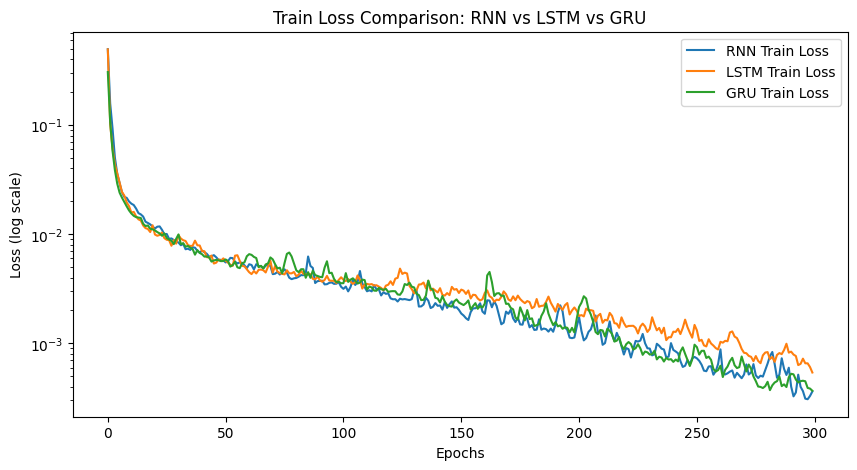

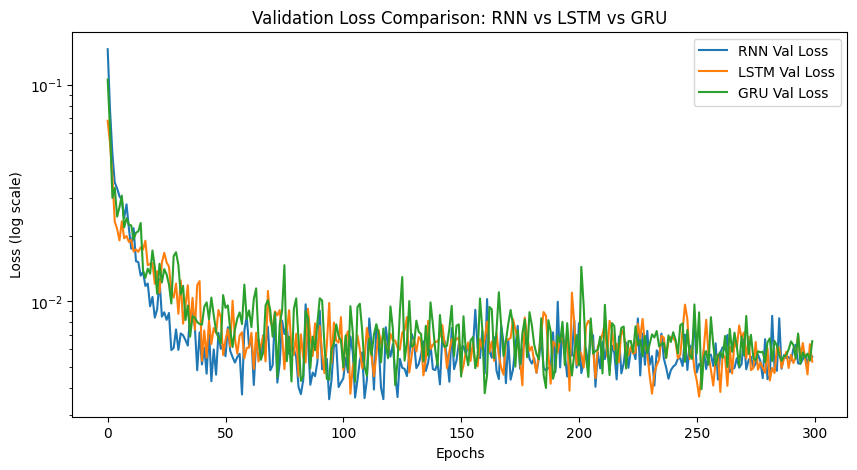

In [234]:
import matplotlib.pyplot as plt

# Train Loss 그래프 (Log scale)
plt.figure(figsize=(10, 5))
plt.plot(rnn_train_losses, label='RNN Train Loss')
plt.plot(lstm_train_losses, label='LSTM Train Loss')
plt.plot(gru_train_losses, label='GRU Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.title('Train Loss Comparison: RNN vs LSTM vs GRU')
plt.yscale('log')  # Log scale 적용
plt.show()

# Validation Loss 그래프 (Log scale)
plt.figure(figsize=(10, 5))
plt.plot(rnn_val_losses, label='RNN Val Loss')
plt.plot(lstm_val_losses, label='LSTM Val Loss')
plt.plot(gru_val_losses, label='GRU Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.title('Validation Loss Comparison: RNN vs LSTM vs GRU')
plt.yscale('log')  # Log scale 적용
plt.show()

In [235]:
# 테스트 성능 평가 함수
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    return test_loss / len(test_loader)

# RNN 모델 평가
rnn_test_loss = evaluate_model(rnn_model, test_loader, criterion)
print(f"RNN Test Loss: {rnn_test_loss:.4f}")

# LSTM 모델 평가
lstm_test_loss = evaluate_model(lstm_model, test_loader, criterion)
print(f"LSTM Test Loss: {lstm_test_loss:.4f}")

# GRU 모델 평가
gru_test_loss = evaluate_model(gru_model, test_loader, criterion)
print(f"GRU Test Loss: {gru_test_loss:.4f}")

RNN Test Loss: 0.0076
LSTM Test Loss: 0.0042
GRU Test Loss: 0.0049


## **분석 및 고찰**

### **tiem step이 길어질 때 모델에 미치는 영향**
- RNN은 긴 시퀀스를 처리할 때 gradient vanishing의 문제가 발생하여 성능이 떨어질 수 있음
- LSTM은 장기적인 의존성을 잘 처리할 수 있는 구조로 긴 시퀀스에서도 비교적 좋은 성능을 유지할 가능성이 높음
- GRU는 LSTM과 비슷한 구조를 가지면서도 간단한 형태로 장기 의존성을 잘 다루지만 LSTM에 비해 성능이 다소 떨어질 가능성이 있음

### **실제 실험 결과**
- time step: 2
    
    RNN Test Loss: 0.0071

    LSTM Test Loss: 0.0039

    GRU Test Loss: 0.0056

- time step: 16
    
    RNN Test Loss: 0.0076

    LSTM Test Loss: 0.0042

    GRU Test Loss: 0.0049


### **전체적인 결과 분석**
- 전체적으로 RNN이 가장 성능이 낮게 나타남.
  - 이는 RNN이 gradient vanishing의 문제로 성능이 떨어진 것으로 생각
- 또한 전체적으로 LSTM 성능이 가장 좋은 것으로 나타남.
  - LSTM의 cell state가 장기 의존성을 잘 처리하여 성능 저하가 적었다고 생각함.
- GRU는 LSTM보다 적은 파라미터를 가지므로 성능이 다소 떨어졌다고 생각함.

### **느낀점**
- 데이터셋 자체가 실제 ETH-USD 주식 데이터에서 가공된 것 같아 이를 이해하고 다루는데에 어려움을 겪었습니다.